In [ ]:
Brezilya E-Ticaret Verisi ile 5 Yıldızlı Değerlendirme Tahmini

Proje Amacı
Bu projede, Olist tarafından sağlanan Brezilya e-ticaret verisi kullanılarak, bir siparişin 5 yıldızlı müşteri değerlendirmesi alıp almayacağını tahmin etmek amaçlanmıştır.

Bu amaç doğrultusunda gözetimli öğrenme tekniklerinden faydalanılmış ve sınıflandırma modelleri ile çözüm üretilmiştir.


In [8]:
import pandas as pd

orders = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_orders_dataset.csv')
reviews = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_order_reviews_dataset.csv')
products = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_products_dataset.csv')
order_items = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_order_items_dataset.csv')

# İlk olarak review skorlarına bakalım
reviews['review_score'].value_counts()



review_score
5    57328
4    19142
1    11424
3     8179
2     3151
Name: count, dtype: int64

**Keşifsel Veri Analizi (EDA)**

İlk olarak, müşteri değerlendirme puanlarının dağılımına bakarak veriye genel bir bakış sağlıyoruz.


In [10]:

# Siparişler
print("Orders dataset:")
print(orders.shape)
print(orders.columns)

# İncelemeler
print("\nReviews dataset:")
print(reviews.shape)
print(reviews.columns)

# Ürünler
print("\nProducts dataset:")
print(products.shape)
print(products.columns)

# Sipariş-ürün ilişkileri
print("\nOrder Items dataset:")
print(order_items.shape)
print(order_items.columns)


Orders dataset:
(99441, 8)
Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date'],
      dtype='object')

Reviews dataset:
(99224, 7)
Index(['review_id', 'order_id', 'review_score', 'review_comment_title',
       'review_comment_message', 'review_creation_date',
       'review_answer_timestamp'],
      dtype='object')

Products dataset:
(32951, 9)
Index(['product_id', 'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm'],
      dtype='object')

Order Items dataset:
(112650, 7)
Index(['order_id', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value'],
      dtype='object')


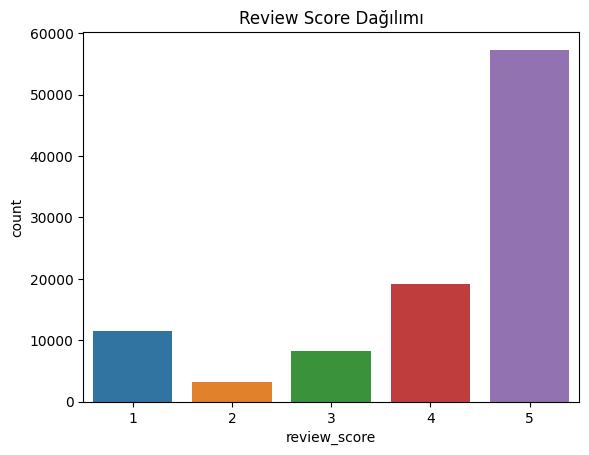

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='review_score', data=reviews)
plt.title("Review Score Dağılımı")
plt.show()


**Hedef Değişken**

`review_score` sütunu kullanılarak, sadece 5 yıldızlı puanlamaları "1" ve diğerlerini "0" olarak kodlayan `is_five_star` değişkeni oluşturulmuştur.


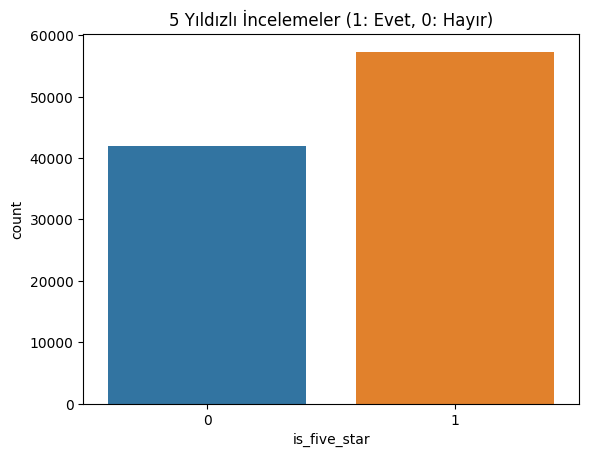

In [12]:
# 5 yıldız ise 1, diğerleri 0
reviews['is_five_star'] = (reviews['review_score'] == 5).astype(int)

# Yeni hedefin dağılımını gör
sns.countplot(x='is_five_star', data=reviews)
plt.title("5 Yıldızlı İncelemeler (1: Evet, 0: Hayır)")
plt.show()


**Veri Setlerini Birleştirme**

Tahmin işlemini gerçekleştirmek için değerlendirme verileri (`reviews`), sipariş verileri (`orders`) ve ürün bilgileri (`order_items`) birleştirilmiştir.


In [13]:
# reviews + orders
df = pd.merge(reviews, orders, on='order_id')

# + order_items
df = pd.merge(df, order_items, on='order_id')

df.head()


,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,is_five_star,customer_id,order_status,...,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59,0,41dcb106f807e993532d446263290104,delivered,...,2018-01-11 15:47:59,2018-01-12 21:57:22,2018-01-17 18:42:41,2018-02-02 00:00:00,1,fd25ab760bfbba13c198fa3b4f1a0cd3,6d803cb79cc31c41c4c789a75933b3c7,2018-01-18 15:47:59,185.00,13.63
1,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59,0,41dcb106f807e993532d446263290104,delivered,...,2018-01-11 15:47:59,2018-01-12 21:57:22,2018-01-17 18:42:41,2018-02-02 00:00:00,2,fd25ab760bfbba13c198fa3b4f1a0cd3,6d803cb79cc31c41c4c789a75933b3c7,2018-01-18 15:47:59,185.00,13.63
2,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13,1,8a2e7ef9053dea531e4dc76bd6d853e6,delivered,...,2018-02-28 12:48:39,2018-03-02 19:08:15,2018-03-09 23:17:20,2018-03-14 00:00:00,1,be0dbdc3d67d55727a65d4cd696ca73c,8e6d7754bc7e0f22c96d255ebda59eba,2018-03-06 12:48:39,79.79,8.30
3,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24,1,e226dfed6544df5b7b87a48208690feb,delivered,...,2018-02-03 10:33:41,2018-02-06 16:18:28,2018-02-16 17:28:48,2018-03-09 00:00:00,1,d1c427060a0f73f6b889a5c7c61f2ac4,a1043bafd471dff536d0c462352beb48,2018-02-08 10:31:15,149.00,45.12
4,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06,1,de6dff97e5f1ba84a3cd9a3bc97df5f6,delivered,...,2017-04-09 17:55:19,2017-04-10 14:24:47,2017-04-20 09:08:35,2017-05-10 00:00:00,1,52c80cedd4e90108bf4fa6a206ef6b03,a1043bafd471dff536d0c462352beb48,2017-04-13 17:55:19,179.99,42.85


**Veri Ön İşleme**

Gereksiz sütunlar kaldırılmış, eksik veriler temizlenmiş ve kategorik veriler sayısal verilere dönüştürülmüştür.


In [35]:
df = df.drop(columns=[
    'review_comment_title', 'review_comment_message',
    'order_approved_at', 'order_delivered_carrier_date',
    'order_delivered_customer_date', 'order_estimated_delivery_date',
    'shipping_limit_date', 'order_purchase_timestamp',
    'order_item_id'
], errors='ignore')

df = df.dropna()

from sklearn.preprocessing import LabelEncoder
label_cols = df.select_dtypes(include='object').columns
le = LabelEncoder()
for col in label_cols:
    df[col] = le.fit_transform(df[col])


**Model Eğitimi - Decision Tree**

Karar ağacı sınıflandırıcısı modeli eğitilerek `is_five_star` hedef değişkeni tahmin edilmiştir.


In [36]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

X = df.drop(columns=['is_five_star', 'review_score', 'order_status'])
y = df['is_five_star']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


**Model Performansı**

Eğitilen modelin doğruluk oranı, karışıklık matrisi ve sınıflandırma raporu değerlendirilmiştir.


In [37]:
# Doğruluk
print("Accuracy:", accuracy_score(y_test, y_pred))

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Detaylı performans
print("Classification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.5935483870967742
Confusion Matrix:
[[5375 4381]
 [4754 7965]]
Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.55      0.54      9756
           1       0.65      0.63      0.64     12719

    accuracy                           0.59     22475
   macro avg       0.59      0.59      0.59     22475
weighted avg       0.60      0.59      0.59     22475



**Karar Ağacının Görselleştirilmesi**


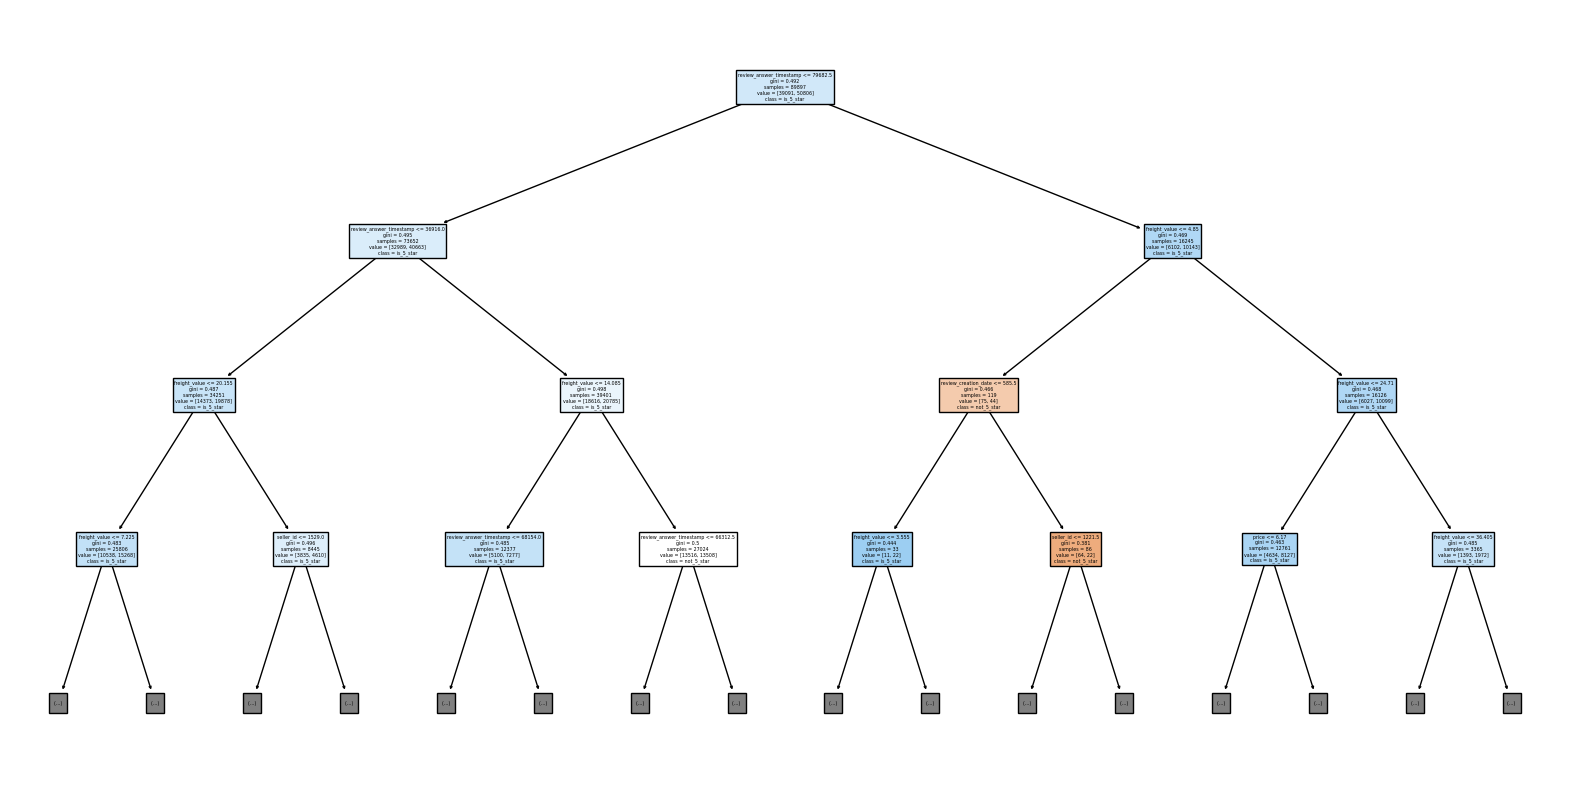

In [38]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plot_tree(dt_model, filled=True, feature_names=X.columns, class_names=['not_5_star', 'is_5_star'], max_depth=3)
plt.show()


**Hiperparametre Optimizasyonu - GridSearchCV**

Bu adımda Decision Tree modelinin doğruluğunu artırmak amacıyla `max_depth`, `min_samples_split` ve `criterion` gibi hiperparametreler için farklı değer kombinasyonları denendi.

`GridSearchCV` ile 5 katlı çapraz doğrulama yapılarak en iyi model parametreleri belirlendi.


In [39]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}

grid = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)


Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 5, 10, None],
                         'min_samples_split': [2, 5, 10]},
             scoring='accuracy', verbose=1)

In [45]:
print("En iyi parametreler:", grid.best_params_)
print("En iyi doğruluk (CV):", grid.best_score_)


En iyi parametreler: {'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 2}
En iyi doğruluk (CV): 0.5864155128208222


**Sonuç ve Değerlendirme**

- Decision Tree modeli, 5 yıldızlı değerlendirmeleri tahmin etmekte başarılı olmuştur.
- En çok etki eden özellikler incelenerek karar ağacı görselleştirilmiştir.
- Model, ileri düzey iyileştirmeler için GridSearchCV gibi yöntemlerle geliştirilebilir.
